# Converting Transactional Sales Data into information useful for a business's marketing strategy development.

Many retail businesses hold data relating to the historical purchases of their customers.  However, in this raw form, this data is not able to inform decisions the business needs to make about how it can increase sales from  its exisiting customers - which is usually far more cost effective than trying to attract new customers.

In circumstances where there is a formal ongoing contract inplace, between the customer and the business (eg. subscriptions), it is self evident when a customer has decided to leave a business.  However, where the relationship is less formal, and therefore less predictable, it may prove very difficult to even know if a business can expect return sales from a particular customer or not.  

Machine Learning algorithms can be used to overcome these difficulties, thereby helping a business to develop its future marketing strategies; targeting specific groups of customers, with campaigns that suit their particular characteristics, thereby increasing the positive results from, and cost effectiveness of, those campaigns.

Machine Learning algorithms can:
- aggregate transactional data into more useful customer level summary information
- calculate the probability that a previous customer has 'churned'; left the business
- predict the number of purchases a customer is likely to mak over any specified period
- predict a Customer's Lifetime Value (total sales) over a specified period
- categorise customers according to their past, or future predicted, potential value to the business.

In this project, I demonstrate how this can be achieved using data provided by a UK Online Retailer, spanning a 12 month period between 2010 and 2011.

## Setting up the project environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from lifetimes import BetaGeoFitter, GammaGammaFitter, BetaGeoBetaBinomFitter
from lifetimes.utils import *
from lifetimes.plotting import *

%matplotlib inline

## Loading, cleaning and transforming the transactional data

In [2]:
# Load transaction data from CSV
df = pd.read_csv('Online_Retail.csv')
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495478 entries, 0 to 495477
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    495478 non-null  object 
 1   StockCode    495478 non-null  object 
 2   Description  494024 non-null  object 
 3   Quantity     495478 non-null  int64  
 4   InvoiceDate  495478 non-null  object 
 5   UnitPrice    495478 non-null  float64
 6   CustomerID   361878 non-null  float64
 7   Country      495478 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 30.2+ MB


In [4]:
df.describe(percentiles=[.25, .50, .75, .95])

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
95%,25.000000,9.950000,17954.000000
max,80995.000000,38970.000000,18287.000000


### Cleaning and transforming the dataset

The following issues exist within the dataset:
1. I need to make sure the date column is in the correct datetime format.
2. It is clear that there are some outlier figures contained in the data for Quantity and UnitPrice:
    - Rows containing negative figures probably relate to returned or cancelled orders and will therefore be removed from the data
    - There are a number of extreme figures in the Quantity and UnitPrice columns.  To prevent these outliers from affecting the results, I shall replace any values over the 95% percentile with the 95% figure in both columns.
2. There are a large number of null values in the CustomerID field, which would not assist in our customer based analysis and therefore can be dropped.
3. We need to create a total sale amount column.

In [5]:
# Convert InvoiceDate into DateTime format and extract the date values
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
# drop rows with missing CustomerID as our analysis will be at the individual customer level
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
# filter out the negative values from Quantity and UnitPrice fields as these could relate to returns that are not relevant to LTV predictions
df = df[(df['Quantity'] > 0)]
df = df[(df['UnitPrice'] > 0)]

# Replace those Quantity and UnitPrice figures over the 95% percentile with the 95% percentile value
p_95 = df['Quantity'].quantile(0.95) # 95th quantile
df['Quantity'].clip(0, p_95, inplace=True)

p_95 = df['UnitPrice'].quantile(0.95) # 95th quantile
df['UnitPrice'].clip(0, p_95, inplace=True)

# create a new column for Sales per invoice and filter out only the required columns for the Lifetimes package
df['SaleAmount'] = df['Quantity'] * df['UnitPrice']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 495477
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    354321 non-null  object 
 1   StockCode    354321 non-null  object 
 2   Description  354321 non-null  object 
 3   Quantity     354321 non-null  float64
 4   InvoiceDate  354321 non-null  object 
 5   UnitPrice    354321 non-null  float64
 6   CustomerID   354321 non-null  float64
 7   Country      354321 non-null  object 
 8   SaleAmount   354321 non-null  float64
dtypes: float64(4), object(5)
memory usage: 27.0+ MB


In [6]:
# Looking at those fields that are integers

df.describe(percentiles=[.25, .50, .75, .95])

,Quantity,UnitPrice,CustomerID,SaleAmount
count,354321.000000,354321.000000,354321.000000,354321.00000
mean,8.348212,2.646190,15552.486392,14.97039
std,9.245021,2.253173,1594.527150,19.73563
min,1.000000,0.001000,12346.000000,0.00100
25%,2.000000,1.250000,14194.000000,4.16000
50%,4.000000,1.950000,15522.000000,10.08000
75%,12.000000,3.750000,16931.000000,17.40000
95%,36.000000,8.500000,17954.000000,45.00000
max,36.000000,8.500000,18287.000000,306.00000


In [7]:
# Looking at those fields that are objects

df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,354321,16646,576339,542
StockCode,354321,3645,85123A,1947
Description,354321,3844,WHITE HANGING HEART T-LIGHT HOLDER,1940
InvoiceDate,354321,305,2011-12-05,3246
Country,354321,1,United Kingdom,354321


### Obtaining some summary metrics from the dataset

In [8]:
# Obtaining some summary metrics from the dataset
print(f"Number of customers in dataset: {df.CustomerID.nunique()}")
print(f"Number of products in dataset: {df.StockCode.nunique()}")
print(f"Number of orders in dataset: {df.InvoiceNo.nunique()}")
print(f"Total sales in the dataset: {df['SaleAmount'].sum()}")
print(f"Date range: {df.InvoiceDate.min()} - {df.InvoiceDate.max()}")

Number of customers in dataset: 3920
Number of products in dataset: 3645
Number of orders in dataset: 16646
Total sales in the dataset: 5304323.574
Date range: 2010-12-01 - 2011-12-09


### Reduce the dataset to the columns required specifically for analysis

In [9]:
df_clean = df[['InvoiceDate', 'CustomerID', 'SaleAmount']]
df_clean

,InvoiceDate,CustomerID,SaleAmount
0,2010-12-01,17850.0,15.30
1,2010-12-01,17850.0,20.34
2,2010-12-01,17850.0,22.00
3,2010-12-01,17850.0,20.34
4,2010-12-01,17850.0,20.34
...,...,...,...
495473,2011-12-09,15804.0,23.40
495474,2011-12-09,13113.0,23.60
495475,2011-12-09,13113.0,30.00
495476,2011-12-09,13113.0,204.00


In [10]:
# Counting the number of sales by each customer
df.groupby(['CustomerID']).size().sort_values(ascending=False)

CustomerID
17841.0    7847
14096.0    5111
12748.0    4595
14606.0    2700
15311.0    2379
           ... 
14351.0       1
13747.0       1
15524.0       1
15802.0       1
12346.0       1
Length: 3920, dtype: int64

### Generating the Recency/Frequency/Monetary-value (RFM) Features Data required by the algorithm

Use the Lifetimes method 'summary_data_from_transaction_data' to obtain the required RFM features.

In [11]:
# transform our transaction level data into the required summary form for Lifetimes at the Daily level
df_rfm = summary_data_from_transaction_data(df_clean, customer_id_col = 'CustomerID', datetime_col = 'InvoiceDate', monetary_value_col = 'SaleAmount', freq = 'D')

df_rfm.head(10)

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12747.0,10.0,367.0,369.0,375.725000
12748.0,112.0,373.0,373.0,252.711607
12749.0,3.0,210.0,213.0,998.866667
12820.0,3.0,323.0,326.0,255.733333
12821.0,0.0,0.0,214.0,0.000000
12822.0,1.0,17.0,87.0,247.780000
12823.0,4.0,222.0,296.0,252.450000
12824.0,0.0,0.0,59.0,0.000000


### Reducing the dataset to those customers who have made repeat purchases with the business

In [12]:
# Only want customers who have a repeat sales history, so we can remove all those with a zero frequency value
df_rfm = df_rfm[df_rfm['frequency']>0]

In [13]:
df_rfm.describe()

,frequency,recency,T,monetary_value
count,2522.000000,2522.000000,2522.000000,2522.000000
mean,4.429818,204.150278,260.901269,321.057116
std,6.613848,111.352794,101.619868,263.021195
min,1.000000,1.000000,9.000000,1.000000
25%,1.000000,107.000000,201.000000,164.441000
50%,3.000000,212.500000,284.000000,269.734886
75%,5.000000,301.000000,358.000000,397.042500
max,112.000000,373.000000,373.000000,3537.620000


## Fitting the RFM data to the Beta Geometric Negative Binomial Distribution (BG/NBD) Model and visualising the results

In [14]:
# fit the BG/NBD model to our data_summary
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(df_rfm['frequency'], df_rfm['recency'], df_rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 2522 subjects, a: 0.01, alpha: 90.66, b: 0.15, r: 1.60>

In [15]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.604986,0.051897,1.503268,1.706704
alpha,90.659304,3.432893,83.930834,97.387775
a,0.006802,0.003447,0.000046,0.013558
b,0.149855,0.074574,0.003690,0.296020


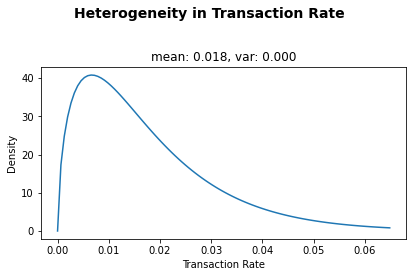

In [16]:
# plot the estimated gamma distribution of λ (customers' propensities to purchase)
plot_transaction_rate_heterogeneity(bgf);

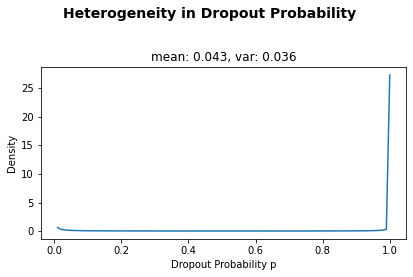

In [17]:
# plot the estimated beta distribution of p, a customers' probability of dropping out immediately after a transaction
plot_dropout_rate_heterogeneity(bgf);

### Comments on the Transaction Rates and Dropout Probability found with the BG/NBD model
Although the transaction rate appears to be heterogeneous across most of the data, the dropout probability is less so, with most of the values being concentrated around 1.0. A potential reason could be the low number of customers with repeat purchases in our data, resulting in a high number of customers therefore likely to have moved on from this business.  Collecting more data over a more extended period may be beneficial.  This may help to ensure the modelling has sufficient data to build predictions upon, but is still likely to have a similar distribution in Dropout.


## Model Visualizations
Once the BG/NBD model has been trained, we can glean useful insights from the following plots:

### 1. Probability of Future Purchasing Heatmap

The heatmap (below) shows the number of transactions that customers are likely to make in the next period (in this case 30 days), based on the transaction frequency seen in our data.

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 30 Units of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

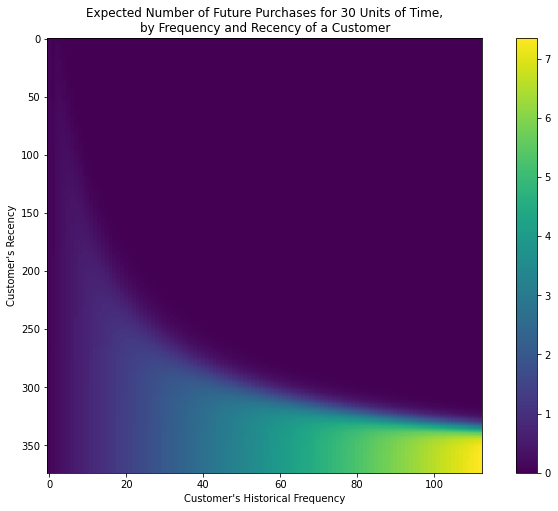

In [18]:
# visualize our frequency/recency matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf, T = 30)

#### Interpreting the Frequency/Recency Heatmap

Intuitively, we can see that customers with high frequency (ie. multiple historical repeat purchases) and high recency (ie. their last repeat purchase was very recent) are expected to purchase more in the future.

So, the best customers are those in the bottom-right of the heatmap, characterized by making more than or equal to 6 repeat purchases, in the next 30 days, with the latest purchase being when they are more than ~330 days old.

In short:

- Customers with multiple repeat purchases (high frequency) and with a higher time gap between their first and latest purchase (high recency) (bottom-right corner) will likely be the best customers in the future
- Customers who have made multiple repeat purchases (high frequency) but with a lower time gap between their first and latest purchase (low recency) (top-right corner) will probably never return
- Customers in the light green and light blue zones are of interest since they may or may not return for purchase, but we can still expect them to purchase about three times over the next 30 days. These are the customers that may need a little cajoling or push to come back and buy more.

## Probability of Alive Heatmap

The heatmap (below) shows the probability that a customer is still 'alive' (ie. likely to make future purchases with this business) given the model parameters:

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

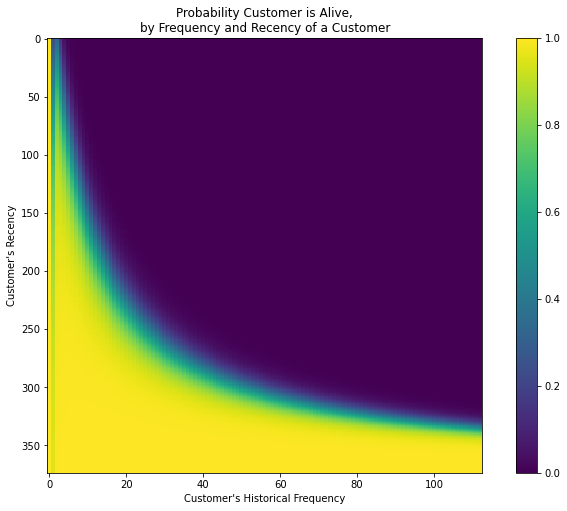

In [19]:
# Now let's visualise the probability of a customer being alive
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

Irrespective of whether a customer purchases frequently or not, its likelihood of being alive is almost 1.0 as long as they have high recency (i.e. a period of more than ~325 days between their first and latest purchase).

Also, customers with slightly lower recency (i.e. the latest purchase was after a relatively short time period from their first purchase) have a higher probability of being alive even if they do not make a high number of repeat purchases.

Customers who have purchased a lot but with shorter recency are likely to have dropped out (top-right quadrant).

### Calculating each customer's probability of being 'Alive'

Visualisation of the overall dataset's properties, in the form of the above graphs, is useful, but to enable us to use data to perform segmentation on the customers, we need to be able to calculate these characteristices at the customer level and add them as features to each customer's record.

The Lifetimes library includes some simple methods that allow us to calculate some useful characteristices.  These include:
- Probability of a customer being 'Alive'
- Predicted number of purchases over a specified period
- Predicted Customer Lifetime Value over a specified period

Once calculated, we can then use these features to divide customers into different groups and develop appropriate marketing strategies for each group.

We start by calculating the probability that each individual remains as a 'Live' customer.

In [20]:
# Late's calculate the probability of each customer being alive and assign the result to each CustomerID
df_rfm['p_alive'] = bgf.conditional_probability_alive(df_rfm['frequency'], df_rfm['recency'], df_rfm['T'])
df_rfm.sort_values(by='p_alive', ascending=True).head(10)

,frequency,recency,T,monetary_value,p_alive
CustomerID,,,,,
17850.0,1.0,1.0,373.0,3537.620,0.244079
16499.0,1.0,4.0,364.0,138.850,0.269830
15224.0,1.0,4.0,362.0,310.480,0.272098
15107.0,5.0,61.0,372.0,36.520,0.278219
17691.0,1.0,10.0,368.0,147.900,0.297714
12967.0,1.0,13.0,371.0,292.500,0.310306
15213.0,1.0,11.0,329.0,15.150,0.354123
16725.0,5.0,69.0,371.0,128.724,0.354460
17334.0,1.0,6.0,308.0,10.500,0.354660


<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

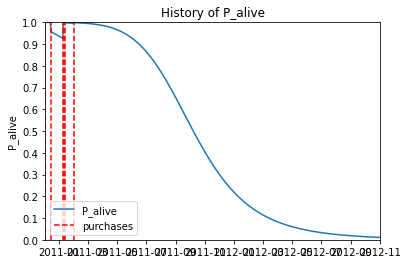

In [21]:
id = 15107
days_since_birth = 700
sp_trans = df_clean.loc[df_clean['CustomerID']==id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

## Model Validation

Up until this stage, we have used all of the data available to us.  This approach does not allow us to make any assessment of how accurate our predictions are, which is essential if we are going to start to predict number of future purchases and possible sales ammounts.  To do that we need to perform model cross-validation, which involves modelling on part of the data, and then make predictions on data that the modelling process has not seen.

To do this we we need to partition our transactional data into calibration and a holdout dataset. We will then use the holdout dataset as production data (not seen during model training), fit a new BG/NBD model on calibration data, and compare the predicted and actual number of repeat purchases over the holdout period.

In order to ensure that we have enough examples within the Training and Testing sets, I have ensured there is a good balance of data split between the two sets (ie. have heldout 200 days of data for Testing).

### Splitting the dataset into Training and Testing sets

In [22]:
summary_cal_holdout = calibration_and_holdout_data(df_clean, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-05-24',
                                        observation_period_end='2011-12-10' )
summary_cal_holdout.describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
count,2428.000000,2428.000000,2428.000000,2428.000000,2428.0
mean,1.422982,46.817133,106.060132,2.651977,200.0
std,3.023503,58.874539,53.731202,4.169707,0.0
min,0.000000,0.000000,0.000000,0.000000,200.0
25%,0.000000,0.000000,62.000000,0.000000,200.0
50%,0.000000,0.000000,111.000000,2.000000,200.0
75%,2.000000,97.000000,162.000000,3.000000,200.0
max,43.000000,174.000000,174.000000,74.000000,200.0


Let's take a quick look at frequency, recency and the T value graphs for the Training data.

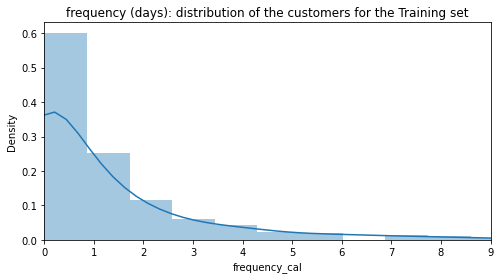

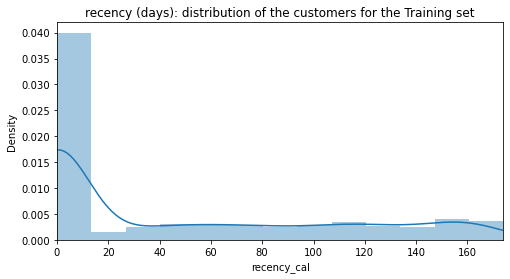

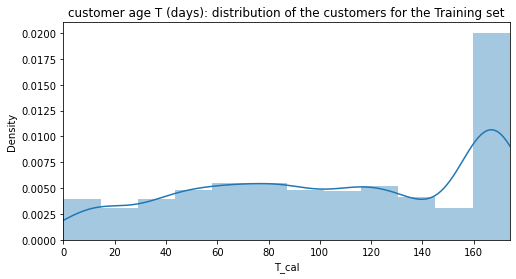

In [23]:
# training: axis length
max_freq = summary_cal_holdout["frequency_cal"].quantile(0.98)
max_rec = summary_cal_holdout["recency_cal"].max()
max_T = summary_cal_holdout["T_cal"].max()

# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(summary_cal_holdout["frequency_cal"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers for the Training set");
plt.show()

# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(summary_cal_holdout["recency_cal"])
ax.set_xlim(0, max_rec)
ax.set_title("recency (days): distribution of the customers for the Training set")
plt.show()

# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(summary_cal_holdout["T_cal"])
ax.set_xlim(0, max_T)
ax.set_title("customer age T (days): distribution of the customers for the Training set")
plt.show()

The customer age T represents the number of days since the buyer’s “birth”, their first day in their role as a new customer of the business: beginning with their first purchase and extending to the end of the dataset. Although there was a peak of customers coming on board 160 or more days in the past. Over its short horizon of approximately 6 months, the charts shows a fairly steady level of new customers coming on board since this peak. The chart suggests that the business does not find itself in a downward trend.

We are able to compare the frequency graphs for the Training and Testing sets.  Whilst we wouldn't expect them to be identical, there should be some similarity in the two distributions. 

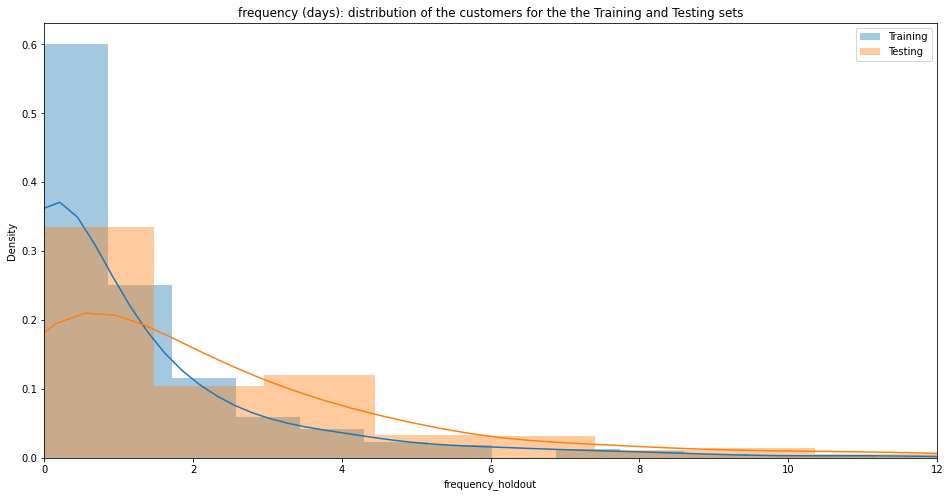

In [24]:
# create the axis lengths for both calibration and holdout sets
max_freq_holdout = summary_cal_holdout["frequency_holdout"].quantile(0.98)
max_freq_cal = summary_cal_holdout["frequency_cal"].quantile(0.98)

fig = plt.figure(figsize=(16,8))

# calibration graph
ax = sns.distplot(summary_cal_holdout["frequency_cal"], label='Training')
ax.set_xlim(0, 12)

# holdout graph
ax = sns.distplot(summary_cal_holdout["frequency_holdout"], label='Testing')
ax.set_title("frequency (days): distribution of the customers for the the Training and Testing sets")

ax.legend(loc='upper right')
plt.show()


We see that they are similar and that there should be sufficient data in both sets to carry out the modelling and testing process.

### Training the BG/NBD model using the Training set

We now calibrate the BG/NBD model with the Test set and then test its performance using the Test set.  

In [25]:
bgf = BetaGeoFitter(penalizer_coef=0.0001)
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'], verbose=True)

Optimization terminated successfully.
         Current function value: -0.241117
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49


<lifetimes.BetaGeoFitter: fitted with 2428 subjects, a: 0.00, alpha: 60.27, b: 0.00, r: 0.74>

### Comparing the Testing model's results to the number of actual transactions

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

<Figure size 864x864 with 0 Axes>

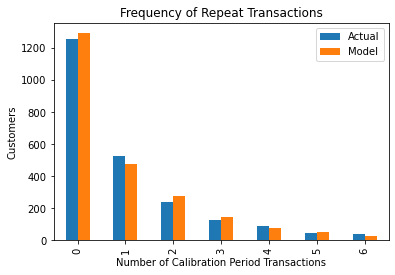

In [26]:
# training: does the model reflect the actual data closely enough?

# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf)

The results predicted by the model, for the Test set, look comparable to the actual results and therefore .

### Using the Trained model to predict the number of purchases in our unseen Test set.

C:\Users\annsc\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

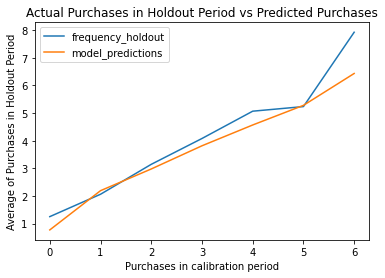

In [27]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

We see that the orange line of model predictions closely hugs the blue actual line, up to 5 transactions per customer. For higher transaction levels, the model starts to underestimate the frequency, probably owing to the rarity of customers who made more than 5 repeat purchases within the short Training time window.

This shows that the model has good predictive peformance and can therefore be used as the basis for the calculation of a Customer's Lifetime Value, which can be predicted using a Gamma-Gamma Model. 

## Estimating Customer Lifetime Value (CLV) using the Gamma-Gamma Model

To ensure that the Gamma-Gamma model is appropriate for use in the prediction of CLV, there must be no correlation between the Monetary Value and Frequency found in our base data.

We can ascertain whether there is a correlation between these two features using the Pearson Correlation Coefficient.  The results should be close to zero, if there is no correlation.

In [31]:
# making sure there is no correlation between frequency and monetary_value
df_rfm[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.00000,0.09635
frequency,0.09635,1.00000


There is no correlation and we can therefore use the Gamma-Gamma model.

We are only interested in, and the model only works effectively, for those customers who have had repeat purchases: we theerfore only model customers with RFM Frequency values greater than zero.

Let's fit the Gamma-Gamma model to our data.

In [32]:
# Calculate the expected number of repeat purchases up to time t for all customers in the dataset,
# for periods of 1 month, 3 months, 6 months and 12 months

# helper function: predict each customer's purchases over next t days
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.predict(
                    t, 
                    df["frequency"], 
                    df["recency"], 
                    df["T"])
                    
                    
# call helper function: predict each customer's purchases over multiple time periods
t_FC = [30, 90, 180, 360]
_ = [predict_purch(df_rfm, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rfm.head()

predicted number of purchases for each customer over next t days:


,frequency,recency,T,monetary_value,p_alive,predict_purch_30,predict_purch_90,predict_purch_180,predict_purch_360
CustomerID,,,,,,,,,
"12,747.0",10.0,367.0,369.0,375.7,1.0,0.8,2.3,4.5,9.0
"12,748.0",112.0,373.0,373.0,252.7,1.0,7.8,23.4,46.8,93.7
"12,749.0",3.0,210.0,213.0,998.9,1.0,0.4,1.2,2.5,4.9
"12,820.0",3.0,323.0,326.0,255.7,1.0,0.3,0.9,1.7,3.5
"12,822.0",1.0,17.0,87.0,247.8,0.9,0.4,1.1,2.1,4.2


In [33]:
df_rfm.sort_values(by='predict_purch_90', ascending=False).head(5)

,frequency,recency,T,monetary_value,p_alive,predict_purch_30,predict_purch_90,predict_purch_180,predict_purch_360
CustomerID,,,,,,,,,
"12,748.0",112.0,373.0,373.0,252.7,1.0,7.8,23.4,46.8,93.7
"17,841.0",111.0,372.0,373.0,344.2,1.0,7.7,23.2,46.4,92.8
"15,311.0",89.0,373.0,373.0,420.8,1.0,6.2,18.6,37.3,74.6
"14,606.0",88.0,372.0,373.0,124.6,1.0,6.1,18.4,36.9,73.7
"12,971.0",70.0,369.0,372.0,131.1,1.0,4.9,14.7,29.5,58.9


<function matplotlib.pyplot.show(close=None, block=None)>

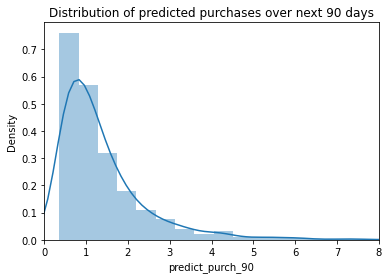

In [34]:
sns.distplot(df_rfm['predict_purch_90']).set_xlim(0,8)
plt.title('Distribution of predicted purchases over next 90 days')
plt.show

In [35]:
df_rfm.describe()

,frequency,recency,T,monetary_value,p_alive,predict_purch_30,predict_purch_90,predict_purch_180,predict_purch_360
count,"2,522.0","2,522.0","2,522.0","2,522.0","2,522.0","2,522.0","2,522.0","2,522.0","2,522.0"
mean,4.4,204.2,260.9,321.1,0.9,0.5,1.4,2.9,5.8
std,6.6,111.4,101.6,263.0,0.1,0.5,1.4,2.9,5.8
min,1.0,1.0,9.0,1.0,0.2,0.1,0.4,0.7,1.4
25%,1.0,107.0,201.0,164.4,0.9,0.2,0.7,1.3,2.7
50%,3.0,212.5,284.0,269.7,1.0,0.4,1.1,2.1,4.3
75%,5.0,301.0,358.0,397.0,1.0,0.6,1.7,3.4,6.8
max,112.0,373.0,373.0,"3,537.6",1.0,7.8,23.4,46.8,93.7


In [36]:
# Let's fit the Gamma-Gamma model to our whole dataset
df_rfm = df_rfm[df_rfm['frequency']>0]
ggf = GammaGammaFitter()
ggf.fit(frequency = df_rfm['frequency'], monetary_value = df_rfm['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2522 subjects, p: 1.58, q: 5.04, v: 854.45>

In [37]:
# After applying Gamma-Gamma model, now we can estimate average transaction value for each customer over his/her lifetime
df_rfm['predicted_Sales'] = ggf.conditional_expected_average_profit(df_rfm['frequency'], df_rfm['monetary_value'])
df_rfm.head()

,frequency,recency,T,monetary_value,p_alive,predict_purch_30,predict_purch_90,predict_purch_180,predict_purch_360,predicted_Sales
CustomerID,,,,,,,,,,
"12,747.0",10.0,367.0,369.0,375.7,1.0,0.8,2.3,4.5,9.0,367.3
"12,748.0",112.0,373.0,373.0,252.7,1.0,7.8,23.4,46.8,93.7,254.5
"12,749.0",3.0,210.0,213.0,998.9,1.0,0.4,1.2,2.5,4.9,693.2
"12,820.0",3.0,323.0,326.0,255.7,1.0,0.3,0.9,1.7,3.5,291.9
"12,822.0",1.0,17.0,87.0,247.8,0.9,0.4,1.1,2.1,4.2,310.0


## Segmenting Customers based on probability of them having churned

We would discuss the businesses risk appetite with the business and marketing teams and agree an appropriate strategy for categorising customers as alive or churned.  Suppose we decide to use the following probability thresholds to classify our customers:

- churned if the probability of being alive is less than 0.5
- high churn risk if the probability of being alive is between 0.5 and 0.75
- not churned otherwise.

We get the following counts:

In [38]:
df_rfm['churn'] = ['churned' if p_alive < 0.5 else 'not churned' for p_alive in df_rfm['p_alive']]
df_rfm['churn'][(df_rfm['p_alive'] >= 0.5) & (df_rfm['p_alive'] < 0.75)] = "high risk"
df_rfm['churn'].value_counts()

not churned    2383
high risk       112
churned          27
Name: churn, dtype: int64

We can use the Gamma-Gamma Model's method, 'conditional_expected_average_profit', to calculate the average transaction for each customer over the lifetime (note that the data only includes sales values, not profit margins, and therefore the actual figure is total sales predicted for each customer, rather than profit.

Final piece of the puzzle - calculate LTV for each customer over the next 3 months with an assumed monthly discount rate of 0.01%

In [39]:
# Calculate LTV for each customer over the next 12 months with an assumed monthly discount rate of 0.01%
df_rfm['12_months_LTV'] = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    df_rfm['frequency'], df_rfm['recency'], df_rfm['T'], df_rfm['monetary_value'],
    time = 12, # number of months to predict LTV for
    discount_rate = 0.01 # monthly discount rate ~ 12.7% annually
)
df_rfm.head()

,frequency,recency,T,monetary_value,p_alive,predict_purch_30,predict_purch_90,predict_purch_180,predict_purch_360,predicted_Sales,churn,12_months_LTV
CustomerID,,,,,,,,,,,,
"12,747.0",10.0,367.0,369.0,375.7,1.0,0.8,2.3,4.5,9.0,367.3,not churned,"3,101.8"
"12,748.0",112.0,373.0,373.0,252.7,1.0,7.8,23.4,46.8,93.7,254.5,not churned,"22,362.4"
"12,749.0",3.0,210.0,213.0,998.9,1.0,0.4,1.2,2.5,4.9,693.2,not churned,"3,200.0"
"12,820.0",3.0,323.0,326.0,255.7,1.0,0.3,0.9,1.7,3.5,291.9,not churned,953.3
"12,822.0",1.0,17.0,87.0,247.8,0.9,0.4,1.1,2.1,4.2,310.0,not churned,"1,233.9"


In [40]:
# Let's identify our top 20 customers based on their 12-months LTV
best_projected_cust_LTV = df_rfm.sort_values('12_months_LTV', ascending=False).head(10)
best_projected_cust_LTV

,frequency,recency,T,monetary_value,p_alive,predict_purch_30,predict_purch_90,predict_purch_180,predict_purch_360,predicted_Sales,churn,12_months_LTV
CustomerID,,,,,,,,,,,,
"14,096.0",16.0,97.0,101.0,"3,012.5",1.0,3.1,9.3,18.7,37.4,"2,643.6",not churned,"92,633.6"
"13,089.0",65.0,367.0,369.0,784.5,1.0,4.6,13.8,27.6,55.1,767.4,not churned,"39,680.6"
"18,102.0",25.0,367.0,367.0,"2,112.8",1.0,1.8,5.4,10.8,21.7,"1,947.9",not churned,"39,616.7"
"17,511.0",27.0,371.0,373.0,"1,784.9",1.0,1.9,5.8,11.5,23.0,"1,659.5",not churned,"35,869.5"
"14,298.0",24.0,352.0,360.0,"1,638.5",1.0,1.8,5.3,10.6,21.2,"1,513.0",not churned,"30,067.7"
"17,841.0",111.0,372.0,373.0,344.2,1.0,7.7,23.2,46.4,92.8,344.0,not churned,"29,955.4"
"15,311.0",89.0,373.0,373.0,420.8,1.0,6.2,18.6,37.3,74.6,418.4,not churned,"29,261.8"
"14,088.0",11.0,312.0,322.0,"3,353.0",1.0,0.9,2.8,5.5,11.1,"2,783.9",not churned,"28,858.8"
"17,450.0",26.0,359.0,367.0,"1,306.7",1.0,1.9,5.6,11.3,22.5,"1,219.7",not churned,"25,769.6"


## Segmentation of Customers on their predicted 12-month LTV

We can now start to segmentise the customers based on the various characteristics we have calculated.

As an example, below we split customers into four equal groups based on their Lifetime Value; Hibernating, Need Attention, Loyal Customers and Champions.

In [41]:
# We now put each customer into a segment depending on their expected purchasing in the next 12 months
df_rfm['Segment'] =  pd.qcut(df_rfm['12_months_LTV'],4,labels = ['Hibernating','Need Attention',
                                                          'Loyal Customers','Champions'])

In [42]:
df_rfm.head()

,frequency,recency,T,monetary_value,p_alive,predict_purch_30,predict_purch_90,predict_purch_180,predict_purch_360,predicted_Sales,churn,12_months_LTV,Segment
CustomerID,,,,,,,,,,,,,
"12,747.0",10.0,367.0,369.0,375.7,1.0,0.8,2.3,4.5,9.0,367.3,not churned,"3,101.8",Champions
"12,748.0",112.0,373.0,373.0,252.7,1.0,7.8,23.4,46.8,93.7,254.5,not churned,"22,362.4",Champions
"12,749.0",3.0,210.0,213.0,998.9,1.0,0.4,1.2,2.5,4.9,693.2,not churned,"3,200.0",Champions
"12,820.0",3.0,323.0,326.0,255.7,1.0,0.3,0.9,1.7,3.5,291.9,not churned,953.3,Need Attention
"12,822.0",1.0,17.0,87.0,247.8,0.9,0.4,1.1,2.1,4.2,310.0,not churned,"1,233.9",Loyal Customers


Let's look at the summary statistics for each of the 4 groups.

In [43]:
segment_means = df_rfm.groupby('Segment').agg(np.mean)
segment_means

,frequency,recency,T,monetary_value,p_alive,predict_purch_30,predict_purch_90,predict_purch_180,predict_purch_360,predicted_Sales,12_months_LTV
Segment,,,,,,,,,,,
Hibernating,1.4,179.1,298.1,202.3,0.9,0.2,0.5,1.1,2.1,286.9,558.1
Need Attention,2.5,194.7,251.4,272.6,1.0,0.3,0.9,1.9,3.7,297.5,974.8
Loyal Customers,3.8,200.4,235.0,345.2,1.0,0.5,1.4,2.8,5.6,332.0,"1,594.7"
Champions,10.0,242.4,259.0,464.1,1.0,1.0,2.9,5.8,11.6,421.1,"4,448.5"


And now we can visualise the difference between the 4 groups. Below we look at the distributions of:
- Probability that customers are still 'Alive'
- Predicted number of purchases over the next 30 days
- Predicted Customer Lifetime Value over the next 12 months

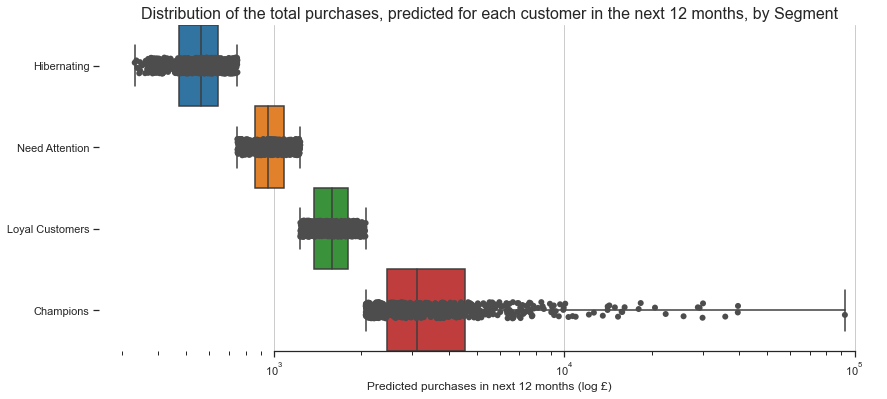

In [44]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(14, 6))
ax.set_xscale("log") # this helps to overcome the effect that large sales by a few customers can have on the graph

# Plot the orbital period with horizontal boxes
sns.boxplot(x="12_months_LTV", y="Segment", data=df_rfm,
            whis=[0, 100], width=1, palette="tab10")

# Add in points to show each observation
sns.stripplot(x="12_months_LTV", y="Segment", data=df_rfm,
              size=6, color="0.3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel="Predicted purchases in next 12 months (log £)")
plt.title("Distribution of the total purchases, predicted for each customer in the next 12 months, by Segment", fontdict={'fontsize': 16})
sns.despine(trim=True, left=True)

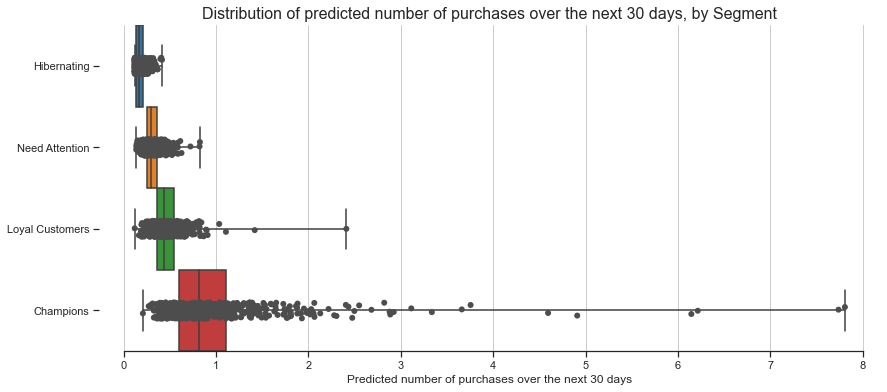

In [54]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(14, 6))
#ax.set_xscale("log") # this helps to overcome the effect that large sales by a few customers can have on the graph

# Plot the orbital period with horizontal boxes
sns.boxplot(x="predict_purch_30", y="Segment", data=df_rfm,
            whis=[0, 100], width=1, palette="tab10")

# Add in points to show each observation
sns.stripplot(x="predict_purch_30", y="Segment", data=df_rfm,
              size=6, color="0.3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel="Predicted number of purchases over the next 30 days")
plt.title("Distribution of predicted number of purchases over the next 30 days, by Segment", fontdict={'fontsize': 16})
sns.despine(trim=True, left=True)

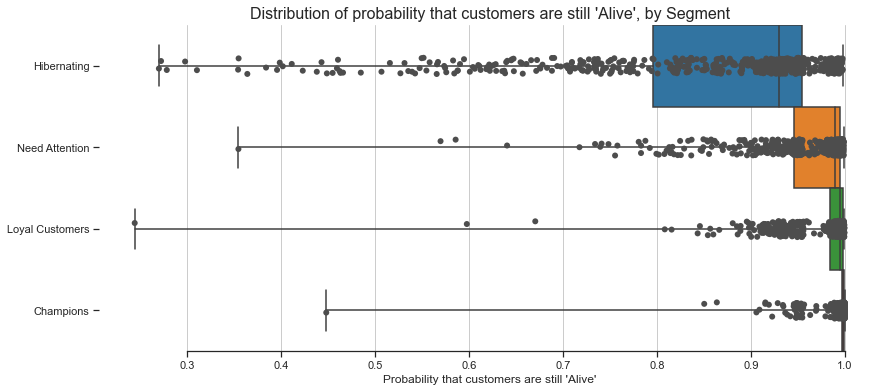

In [72]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(14, 6))
#ax.set_xscale("log") # this helps to overcome the effect that large sales by a few customers can have on the graph

# Plot the orbital period with horizontal boxes
sns.boxplot(x="p_alive", y="Segment", data=df_rfm,
            whis=[0, 100], width=1, palette="tab10")

# Add in points to show each observation
sns.stripplot(x="p_alive", y="Segment", data=df_rfm,
              size=6, color="0.3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel="Probability that customers are still 'Alive'")
plt.title("Distribution of probability that customers are still 'Alive', by Segment", fontdict={'fontsize': 16})
sns.despine(trim=True, left=True)

### Who are the valuable customers that are likely to churn? 
Below, we identify those customers who have a 'High Risk' of churning, but are not 'Hibernating', with a view to prioritising contact with them to encourage future purchases.

In [46]:
at_risk_customers = df_rfm[df_rfm['churn']=='high risk']
high_risk_valuable = at_risk_customers[at_risk_customers['Segment']!='Hibernating']
high_risk_valuable

,frequency,recency,T,monetary_value,p_alive,predict_purch_30,predict_purch_90,predict_purch_180,predict_purch_360,predicted_Sales,churn,12_months_LTV,Segment
CustomerID,,,,,,,,,,,,,
"13,730.0",1.0,26.0,161.0,445.8,0.7,0.2,0.7,1.4,2.8,365.7,high risk,968.9,Need Attention
"13,819.0",2.0,18.0,319.0,324.4,0.6,0.2,0.6,1.3,2.6,330.0,high risk,803.8,Need Attention
"13,952.0",1.0,21.0,238.0,"1,177.0",0.6,0.2,0.5,1.0,2.1,571.4,high risk,"1,122.9",Need Attention
"14,002.0",1.0,22.0,156.0,298.5,0.7,0.2,0.7,1.4,2.9,324.3,high risk,878.9,Need Attention
"14,024.0",1.0,3.0,124.0,65.2,0.7,0.3,0.8,1.7,3.4,258.7,high risk,822.9,Need Attention
"14,245.0",1.0,44.0,263.0,679.0,0.6,0.2,0.5,1.0,1.9,431.3,high risk,782.1,Need Attention
"14,331.0",1.0,11.0,135.0,79.0,0.7,0.3,0.8,1.6,3.2,262.5,high risk,788.1,Need Attention
"15,235.0",9.0,156.0,373.0,238.7,0.6,0.7,2.0,4.0,8.1,259.8,high risk,"1,971.6",Loyal Customers
"15,808.0",3.0,63.0,369.0,894.6,0.7,0.3,0.8,1.6,3.1,636.9,high risk,"1,871.6",Loyal Customers


### Which higher value customers have churned?
And here we identify those high value customers who appear to have churned, so that we can possibly approach them with specific offers to encourage them to return.

In [47]:
churned_customers = df_rfm[df_rfm['churn']=='churned']
churned_valuable = churned_customers[churned_customers['Segment']!='Hibernating']
churned_valuable

,frequency,recency,T,monetary_value,p_alive,predict_purch_30,predict_purch_90,predict_purch_180,predict_purch_360,predicted_Sales,churn,12_months_LTV,Segment
CustomerID,,,,,,,,,,,,,
"13,093.0",6.0,98.0,373.0,941.9,0.4,0.5,1.4,2.8,5.6,760.4,churned,"3,991.8",Champions
"16,725.0",5.0,69.0,371.0,128.7,0.4,0.4,1.2,2.4,4.8,198.3,churned,890.4,Need Attention
"17,850.0",1.0,1.0,373.0,"3,537.6",0.2,0.1,0.4,0.7,1.4,"1,235.3",churned,"1,671.3",Loyal Customers


### What products did the churned, higher value, customers purchase most frequently?

In [90]:
df_valuable = pd.merge(left=churned_valuable, right=df, on='CustomerID')
df_valuable.value_counts('Description').head(10)

Description
WHITE HANGING HEART T-LIGHT HOLDER     19
RED WOOLLY HOTTIE WHITE HEART.         18
HAND WARMER UNION JACK                 17
HAND WARMER RED POLKA DOT              17
GLASS STAR FROSTED T-LIGHT HOLDER      17
KNITTED UNION FLAG HOT WATER BOTTLE    17
WHITE METAL LANTERN                    17
SET 7 BABUSHKA NESTING BOXES           16
RETRO COFFEE MUGS ASSORTED             16
WOODEN FRAME ANTIQUE WHITE             16
dtype: int64

## Conclusion

Using the segmenting of customers a business can consider;
- Specific communication with each of the segments;
- Offering offers on specific products to each segment;
- Creating a marketing plan to increase Customer Value for the lower segments;
- Focusing efforts on those at higher risk of churning, to avoid losing them.